# Generative Modeling with GANs (EEG Data Augmentation)

**Objective:**
Design and implement a Conditional Wasserstein GAN with Gradient Penalty (WGAN-GP) to learn the distribution of EEG segments and generate synthetic EEG data conditioned on an emotion label (e.g. “positive” or “negative”). This synthetic data can later be used to augment your limited EEG dataset.

**Why have we decided to go with this approach of Conditional Wasserstein GAN?**
The rationale is based on the research of these papers.
- [Deep Convolutional Neural Network-Based Visual Stimuli Classification Using Electroencephalography Signals of Healthy and Alzheimer’s Disease Subjects](https://pmc.ncbi.nlm.nih.gov/articles/PMC8950142/)
- [Generative adversarial networks in EEG analysis: an overview](https://jneuroengrehab.biomedcentral.com/articles/10.1186/s12984-023-01169-w)
- [Data Augmentation for EEG-Based Emotion Recognition Using Generative Adversarial Networks](https://www.frontiersin.org/journals/computational-neuroscience/articles/10.3389/fncom.2021.723843/full)

we already had some initial research on why GAN's work, which is more detailed on the Frintiers paper above, but because of the conditional WGAN results on augmentation of emotion EEG data, we chose this approach.

**Research question overview**
- Can deep generative models produce realistic EEG signals in both the time and frequency domains?
- Does conditioning on the class label allow generation of class-specific patterns (i.e., can we generate EEG that resembles “positive” vs. “negative” emotion)?


**Team Contributions:**
- **Rahul:** Overall project integration, detailed documentation, and Implementation of the GAN models and training loop.
- **Aarohi:** Evaluation, and improvement, with an additional help in research.

In this notebook, we have:
1. Defined the generator and discriminator architectures (adapted for multichannel time-series EEG).
2. Implemented the WGAN-GP training loop.
3. Visualized training progress and sample outputs.
4. Explained why we did, what we did I guess.

In [3]:
# imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import mne
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.signal import welch
import matplotlib
%matplotlib inline
import seaborn as sns

# Set the aesthetic style for plots
sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.2)

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# setting device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

Using device: mps


### Hyperparameters and Data Dimensions

we define key hyperparameters, such as the latent dimension, number of channels, signal length, number of classes

- **latent_dim:** 100
- **n_channels:** 63
- **signal_len:** 1000 (5 sec at 200 Hz)
- **num_classes:** 2

also set training hyperparameters

In [15]:
latent_dim = 100
n_channels = 63
signal_len = 1000    # 5 seconds at 200 Hz
num_classes = 2

target_signal_len = 1001

batch_size = 64
learning_rate = 5e-5
lambda_gp = 10
num_epochs = 500    #This for a full training, can be less for testing

### GAN Architectures

I now define our **Generator** and **Discriminator**. Since our EEG epochs are 63 channels × 1000 samples, we adjust the network accordingly.

**Generator:**
- Input: A noise vector (100-D) concatenated with a one-hot encoded label (2-D).
- Fully-connected layer: Projects the combined vector to a feature map of size 256 × (signal_len/8). I use `signal_len // 8` because with 3 transposed convolution layers (each with stride=2) we upscale from 125 to 250 to 500 to 1000 samples. Once testing out this approach, we identified that some EEG epochs did not follow this upscaling because of timestamps, We then defined our generator to produce epochs of exactly target_signal_len timepoints. The generator first computes a base length: target_signal_len // 8 (since we upsample by a factor of 8 over 3 ConvTranspose1d layers). Then it calculates the remainder: target_signal_len - base_length*8. Finally, in the last ConvTranspose1d layer we set output_padding=remainder, so that the final output has the correct length.
For example, if target_signal_len = 1001, then base_length = 125 (since 125*8 = 1000) and remainder = 1.

**Discriminator:**
- Input: An EEG epoch with shape (63, 1000) plus a label appended as extra channels.
- Uses 1D convolution layers to downsample the signal and produce a scalar score.


In [5]:
class EEGGenerator(nn.Module):
    def __init__(self, latent_dim=100, n_channels=63, target_signal_len=1001, num_classes=2):
        super().__init__()
        self.n_channels = n_channels
        self.target_signal_len = target_signal_len
        self.num_classes = num_classes

        self.base_length = target_signal_len // 8
        remainder = target_signal_len - (self.base_length * 8)

        self.fc = nn.Linear(latent_dim + num_classes, 256 * self.base_length)

        self.deconv_blocks = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=False),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=False),
            nn.ConvTranspose1d(64, n_channels, kernel_size=4, stride=2, padding=1, output_padding=remainder),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), 256, self.base_length)
        out = self.deconv_blocks(x)
        return out

In [6]:
class EEGDiscriminator(nn.Module):
    def __init__(self, n_channels=63, target_signal_len=1001, num_classes=2):
        super().__init__()
        self.n_channels = n_channels
        self.target_signal_len = target_signal_len
        self.num_classes = num_classes

        self.conv_blocks = nn.Sequential(
            nn.Conv1d(n_channels + num_classes, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Conv1d(128, 1, kernel_size=4, stride=2, padding=1)
        )

    def forward(self, eeg, labels):
        label_expand = labels.unsqueeze(2).repeat(1, 1, eeg.shape[2])
        d_in = torch.cat([eeg, label_expand], dim=1)
        out = self.conv_blocks(d_in)
        return out.mean(dim=2)

In [7]:
# Updated the Discriminator because we wanted to address identified amplitude and frequency realism issues.
# No that will happen if we just make the discriminator better so that it will also make generator work "hard" i guess to improve the synthetic data quality.

class EEGDiscriminatorEnhanced(nn.Module):
    def __init__(self, n_channels=63, target_signal_len=1001, num_classes=2):
        super().__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv1d(n_channels + num_classes, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv1d(256, 1, kernel_size=4, stride=2, padding=1)
        )

    def forward(self, eeg, labels):
        labels_expand = labels.unsqueeze(2).repeat(1, 1, eeg.shape[2])
        d_in = torch.cat([eeg, labels_expand], dim=1)
        out = self.conv_blocks(d_in)
        return out.mean(dim=2)

### Load Preprocessed EEG Data

Here I load the preprocessed EEG epochs produced by our `preprocessor_all_data.py` module. I am loading all subjects, extract the epoch data and create one-hot encoded labels for binary classification.


In [8]:
def load_all_preprocessed_data(preprocessed_root="./../data/preprocessed/"):
    subject_folders = [d for d in os.listdir(preprocessed_root) if os.path.isdir(os.path.join(preprocessed_root, d))]
    all_data = []
    all_labels = []

    for subj in subject_folders:
        fif_path = os.path.join(preprocessed_root, subj, "preprocessed_epochs-epo.fif")
        if os.path.exists(fif_path):
            epochs = mne.read_epochs(fif_path, preload=True)
            data = epochs.get_data()
            events = epochs.events


            labels_int = events[:, 2]
            unique_codes = np.unique(labels_int)

            # If only one event code is found, randomly split epochs into two classes.
            if len(unique_codes) < 2:
                print(f"Subject {subj}: Only one event code found. Randomly splitting epochs into two classes.")
                n_epochs = data.shape[0]
                # Randomly shuffle indices and split into two halves.
                indices = np.arange(n_epochs)
                np.random.shuffle(indices)
                labels_int = np.zeros(n_epochs, dtype=int)
                split_idx = n_epochs // 2
                labels_int[indices[split_idx:]] = 1
            else:
                # If more than two codes, take only the first two
                if len(unique_codes) > 2:
                    unique_codes = unique_codes[:2]
                mapping = {unique_codes[0]: 0, unique_codes[1]: 1}
                labels_int = np.vectorize(lambda x: mapping.get(x, 0))(labels_int)

            # One-hot encode the labels
            labels_onehot = np.zeros((len(labels_int), num_classes))
            labels_onehot[np.arange(len(labels_int)), labels_int] = 1

            all_data.append(data)
            all_labels.append(labels_onehot)
        else:
            print(f"File {fif_path} not found. Skipping subject {subj}.")

    if len(all_data) == 0:
        raise RuntimeError("No preprocessed data found.")

    # Concatenate data across subjects
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    print("Loaded preprocessed EEG data shape:", all_data.shape)
    print("Loaded labels shape:", all_labels.shape)
    return all_data, all_labels

In [9]:
# load all the data
all_data, all_labels = load_all_preprocessed_data()

Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/exploratory notebooks/../data/preprocessed/Sub42/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/exploratory notebooks/../data/preprocessed/Sub11/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
28 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/rahul/PycharmProjects/Semester 5/gnn-project/exploratory notebooks/../data/preprocessed/Sub29/preprocessed_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    5000.00 ms


In [10]:
# Convert data to torch tensors (ensure float32 for EEG and float32 for labels)
real_EEG = torch.from_numpy(all_data.astype(np.float32))
real_labels = torch.from_numpy(all_labels.astype(np.float32))
print("Torch EEG data shape:", real_EEG.shape)
print("Torch labels shape:", real_labels.shape)

Torch EEG data shape: torch.Size([901, 63, 1001])
Torch labels shape: torch.Size([901, 2])


### Instantiate Models and Optimizers


In [16]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # for windows
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

# Set target signal length based on real data
target_signal_len = real_EEG.shape[2]
print("Target signal length:", target_signal_len)

# Instantiate generators for fair comparison
generator_original = EEGGenerator(latent_dim, n_channels, target_signal_len, num_classes).to(device)
generator_enhanced = EEGGenerator(latent_dim, n_channels, target_signal_len, num_classes).to(device)

# Instantiate both discriminators
# Original Discriminator
discriminator_original = EEGDiscriminator(n_channels, target_signal_len, num_classes).to(device)

# Enhanced Discriminator
discriminator_enhanced = EEGDiscriminatorEnhanced(n_channels, target_signal_len, num_classes).to(device)

# Optimizers
optimizer_G_original = optim.Adam(generator_original.parameters(), lr=learning_rate, betas=(0.5, 0.9))
optimizer_D_original = optim.Adam(discriminator_original.parameters(), lr=learning_rate, betas=(0.5, 0.9))

optimizer_G_enhanced = optim.Adam(generator_enhanced.parameters(), lr=learning_rate, betas=(0.5, 0.9))
optimizer_D_enhanced = optim.Adam(discriminator_enhanced.parameters(), lr=learning_rate, betas=(0.5, 0.9))


Using device: mps
Target signal length: 1001


In [12]:
# Create a DataLoader
dataset = TensorDataset(real_EEG, real_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Gradient Penalty Function for WGAN-GP

This function computes the gradient penalty required for WGAN-GP.

In [13]:
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    # Create a random weight tensor
    alpha = torch.rand(real_samples.size(0), 1, 1, device=real_samples.device)
    # Compute interpolates and force it to require gradients.
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).clone().detach()
    interpolates.requires_grad_(True)

    d_interpolates = D(interpolates, labels)
    grad_outputs = torch.ones(d_interpolates.size(), device=real_samples.device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

### Spectral Loss

This is new loss for frequency domain for PSD alignment.

In [14]:
def spectral_loss(real_signal, fake_signal, fs=200, nperseg=256):
    real_psd = welch(real_signal.cpu().detach().numpy(), fs=fs, nperseg=nperseg)[1]
    fake_psd = welch(fake_signal.cpu().detach().numpy(), fs=fs, nperseg=nperseg)[1]
    real_psd_tensor = torch.from_numpy(real_psd).to(real_signal.device)
    fake_psd_tensor = torch.from_numpy(fake_psd).to(fake_signal.device)
    return torch.mean((real_psd_tensor - fake_psd_tensor)**2)

### Training Loop for Conditional WGAN-GP

For each batch, we:
1. Update the discriminator n_critic times by comparing its outputs on real and fake EEG, plus the gradient penalty.
2. Update the generator by maximizing the discriminator's output on fake EEG.

We record losses to monitor training progress.

In [17]:
def train_WGAN_GP(generator, discriminator, dataloader, optimizer_G, optimizer_D,
                  latent_dim, n_critic, lambda_gp, num_epochs, device, use_spectral_loss=False, spectral_loss_weight=1.0):

    G_losses, D_losses = [], []

    print("Starting training...")
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        for real_batch, labels in dataloader:
            real_batch, labels = real_batch.to(device), labels.to(device)
            current_batch_size = real_batch.size(0)

            # Update Discriminator
            for _ in range(n_critic):
                noise = torch.randn(current_batch_size, latent_dim).to(device)
                fake_EEG = generator(noise, labels)

                D_real = discriminator(real_batch, labels)
                D_fake = discriminator(fake_EEG.detach(), labels)
                gp = compute_gradient_penalty(discriminator, real_batch, fake_EEG.detach(), labels)
                D_loss = D_fake.mean() - D_real.mean() + lambda_gp * gp

                optimizer_D.zero_grad()
                D_loss.backward()
                optimizer_D.step()

            # Update Generator
            noise = torch.randn(current_batch_size, latent_dim).to(device)
            fake_EEG = generator(noise, labels)
            G_loss = -discriminator(fake_EEG, labels).mean()

            # Add Spectral Loss if enabled
            if use_spectral_loss:
                spec_loss = spectral_loss(real_batch, fake_EEG)
                G_loss += spectral_loss_weight * spec_loss

            optimizer_G.zero_grad()
            G_loss.backward()
            optimizer_G.step()

            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())

        if (epoch+1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | D_loss: {D_loss.item():.4f} | G_loss: {G_loss.item():.4f}")

    print("Training complete.")
    return G_losses, D_losses

In [18]:
# Training original model
G_losses_orig, D_losses_orig = train_WGAN_GP(
    generator_original, discriminator_original, dataloader, optimizer_G_original,
    optimizer_D_original, latent_dim, n_critic=5, lambda_gp=10, num_epochs=300,
    device=device, use_spectral_loss=False
)

Starting training...


Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch [20/300] | D_loss: -737.4174 | G_loss: 49.4104
Epoch [40/300] | D_loss: -622.7838 | G_loss: -89.6584
Epoch [60/300] | D_loss: -349.7450 | G_loss: -472.7063
Epoch [80/300] | D_loss: -124.4734 | G_loss: -537.2461
Epoch [100/300] | D_loss: -138.8485 | G_loss: -603.7921
Epoch [120/300] | D_loss: -136.5610 | G_loss: -935.2455
Epoch [140/300] | D_loss: -170.9616 | G_loss: -1560.2762
Epoch [160/300] | D_loss: -220.4263 | G_loss: -2589.8696
Epoch [180/300] | D_loss: -281.2697 | G_loss: -4349.4443
Epoch [200/300] | D_loss: -449.4932 | G_loss: -6443.9736
Epoch [220/300] | D_loss: -319.5541 | G_loss: -7825.4219
Epoch [240/300] | D_loss: -291.9016 | G_loss: -8391.1240
Epoch [260/300] | D_loss: -310.9954 | G_loss: -8661.5498
Epoch [280/300] | D_loss: -404.3917 | G_loss: -8854.4521
Epoch [300/300] | D_loss: -510.8223 | G_loss: -8908.6016
Training complete.


In [19]:
# Training Enhanced model
G_losses_enh, D_losses_enh = train_WGAN_GP(
    generator_enhanced, discriminator_enhanced, dataloader, optimizer_G_enhanced,
    optimizer_D_enhanced, latent_dim, n_critic=5, lambda_gp=10, num_epochs=300,
    device=device, use_spectral_loss=True, spectral_loss_weight=0.1
)

Starting training...


Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch [20/300] | D_loss: -1202.3844 | G_loss: -248.5365
Epoch [40/300] | D_loss: -459.3073 | G_loss: -745.3579
Epoch [60/300] | D_loss: -290.4977 | G_loss: -1014.4694
Epoch [80/300] | D_loss: -297.3216 | G_loss: -2037.5031
Epoch [100/300] | D_loss: -376.4177 | G_loss: -3214.6836
Epoch [120/300] | D_loss: -259.0533 | G_loss: -3909.9382
Epoch [140/300] | D_loss: -279.9059 | G_loss: -4946.0000
Epoch [160/300] | D_loss: -358.4440 | G_loss: -4775.1978
Epoch [180/300] | D_loss: -273.0197 | G_loss: -4808.2490
Epoch [200/300] | D_loss: -191.2082 | G_loss: -4854.1416
Epoch [220/300] | D_loss: -194.7570 | G_loss: -4880.0439
Epoch [240/300] | D_loss: -366.2221 | G_loss: -4596.8306
Epoch [260/300] | D_loss: -378.8285 | G_loss: -3893.1892
Epoch [280/300] | D_loss: -357.8273 | G_loss: -3545.8054
Epoch [300/300] | D_loss: -348.7125 | G_loss: -2886.1057
Training complete.


### Plot Training Losses

Plot the evolution of generator and discriminator losses to assess training stability.

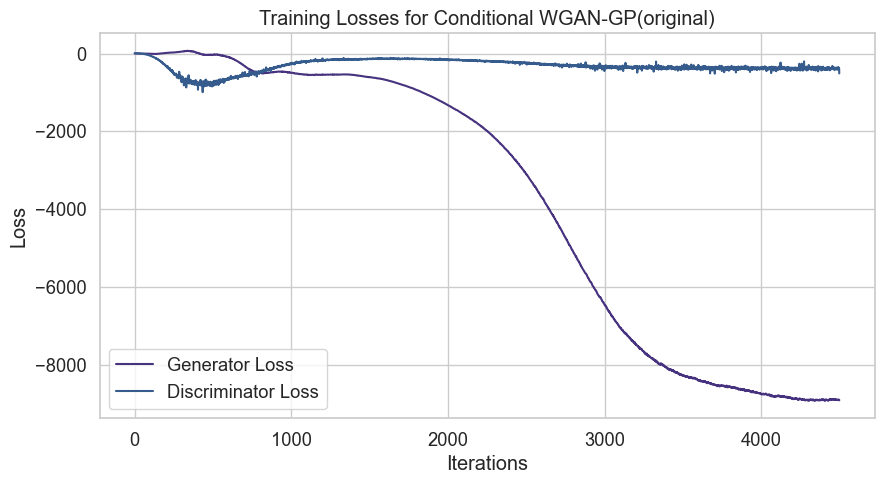

In [20]:
plt.figure(figsize=(10,5))
plt.plot(G_losses_orig, label="Generator Loss")
plt.plot(D_losses_orig, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Losses for Conditional WGAN-GP(original)")
plt.legend()
plt.show()

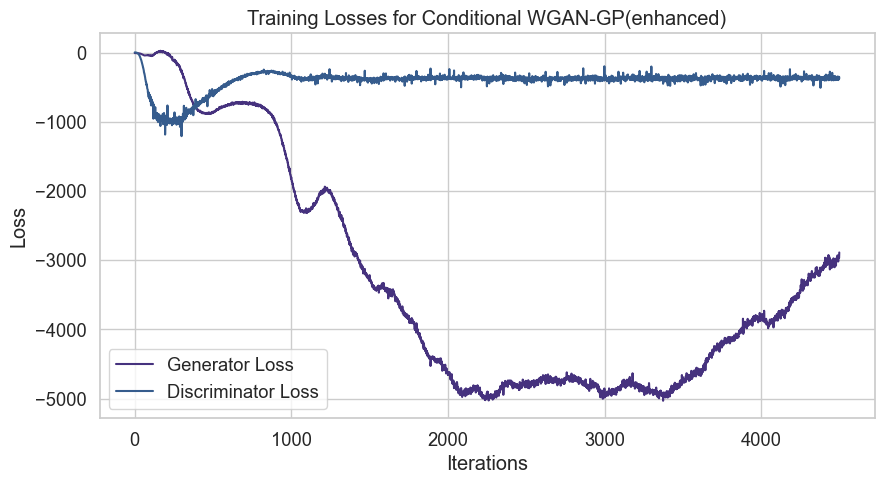

In [21]:
plt.figure(figsize=(10,5))
plt.plot(G_losses_enh, label="Generator Loss")
plt.plot(D_losses_enh, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Losses for Conditional WGAN-GP(enhanced)")
plt.legend()
plt.show()

### Hyperparameter Tuning
Implementing a function to train the conditional WGAN-GP while tuning hyperparameters and using early stopping.

**Early Stopping:** Monitors the validation loss; if no improvement is seen for a specified number of epochs (patience), training stops.

**Hyperparameter Tuning:** You can use a grid or random search. Here we define a function that accepts a dictionary of hyperparameters.

In [22]:
def tune_cWGAN(
    hyperparams_list,
    generator_class,
    discriminator_class,
    train_loader,
    val_loader,
    latent_dim=100,
    device='cuda',
    patience=50,
    model_save_dir='./models'
):
    os.makedirs(model_save_dir, exist_ok=True)

    best_val_loss = float('inf')
    best_config = None
    best_gen_state = None
    best_disc_state = None

    best_G_losses = []
    best_D_losses = []
    best_val_losses = []

    for idx, params in enumerate(hyperparams_list):
        print(f"\nTraining model with config #{idx + 1}: {params}")
        generator = generator_class(latent_dim, n_channels, target_signal_len, num_classes).to(device)
        discriminator = discriminator_class(n_channels, target_signal_len, num_classes).to(device)

        optimizer_G = optim.Adam(generator.parameters(), lr=params['lr'], betas=(0.5, 0.9))
        optimizer_D = optim.Adam(discriminator.parameters(), lr=params['lr'], betas=(0.5, 0.9))

        epochs_no_improve = 0
        local_best_val_loss = float('inf')

        G_losses, D_losses, val_losses_per_epoch = [], [], []

        for epoch in tqdm(range(params['num_epochs']), desc=f"Config {idx + 1} Epochs"):
            generator.train()
            discriminator.train()

            epoch_G_loss, epoch_D_loss = 0, 0
            iterations = 0

            for real_batch, labels in train_loader:
                real_batch, labels = real_batch.to(device), labels.to(device)
                current_batch_size = real_batch.size(0)

                for _ in range(params['n_critic']):
                    noise = torch.randn(current_batch_size, latent_dim).to(device)
                    fake_EEG = generator(noise, labels)
                    D_real = discriminator(real_batch, labels)
                    D_fake = discriminator(fake_EEG.detach(), labels)
                    gp = compute_gradient_penalty(discriminator, real_batch, fake_EEG.detach(), labels)
                    D_loss = D_fake.mean() - D_real.mean() + params['lambda_gp'] * gp

                    optimizer_D.zero_grad()
                    D_loss.backward()
                    optimizer_D.step()

                noise = torch.randn(current_batch_size, latent_dim).to(device)
                fake_EEG = generator(noise, labels)
                G_loss = -discriminator(fake_EEG, labels).mean()

                optimizer_G.zero_grad()
                G_loss.backward()
                optimizer_G.step()

                epoch_G_loss += G_loss.item()
                epoch_D_loss += D_loss.item()
                iterations += 1

            # Save average epoch loss
            G_losses.append(epoch_G_loss / iterations)
            D_losses.append(epoch_D_loss / iterations)

            # Compute validation loss
            generator.eval()
            discriminator.eval()
            val_loss_epoch = 0
            with torch.no_grad():
                for real_batch, labels in val_loader:
                    real_batch, labels = real_batch.to(device), labels.to(device)
                    current_batch_size = real_batch.size(0)
                    noise = torch.randn(current_batch_size, latent_dim).to(device)
                    fake_EEG = generator(noise, labels)
                    D_real = discriminator(real_batch, labels)
                    D_fake = discriminator(fake_EEG, labels)
                    val_loss = D_fake.mean() - D_real.mean()
                    val_loss_epoch += val_loss.item()
            val_loss_epoch /= len(val_loader)
            val_losses_per_epoch.append(val_loss_epoch)

            # Early stopping check
            if val_loss_epoch < local_best_val_loss:
                local_best_val_loss = val_loss_epoch
                epochs_no_improve = 0
                temp_gen_state = generator.state_dict()
                temp_disc_state = discriminator.state_dict()
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"Early stopping at epoch {epoch + 1}. Best val_loss: {local_best_val_loss:.4f}")
                    break

        if local_best_val_loss < best_val_loss:
            best_val_loss = local_best_val_loss
            best_config = params
            best_gen_state = temp_gen_state
            best_disc_state = temp_disc_state
            best_G_losses = G_losses
            best_D_losses = D_losses
            best_val_losses = val_losses_per_epoch

    torch.save(best_gen_state, os.path.join(model_save_dir, 'best_generator.pth'))
    torch.save(best_disc_state, os.path.join(model_save_dir, 'best_discriminator.pth'))

    print("\nBest Hyperparameters found:")
    for key, val in best_config.items():
        print(f" - {key}: {val}")
    print(f"Best validation loss: {best_val_loss:.4f}")

    return best_config, best_val_loss, best_G_losses, best_D_losses, best_val_losses

## 8. Split Data into Training and Validation Sets

We split the dataset into training and validation sets (e.g., 90% training, 10% validation) to enable early stopping.



In [23]:
from sklearn.model_selection import train_test_split

X = real_EEG.numpy()
Y = real_labels.numpy()

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

train_dataset = TensorDataset(torch.from_numpy(X_train.astype(np.float32)), torch.from_numpy(Y_train.astype(np.float32)))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(Y_val.astype(np.float32)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## 9. Train the Conditional WGAN-GP(original and enhanced) with Hyperparameter Tuning and Early Stopping

We now train our cWGAN-GP using the tuning function. Adjust hyperparameters as needed.

We are also tuning enhanced model which we created after evaluating original. We are using both in this notebook to see the progress



In [24]:
# Define a list of hyperparameter configurations
hyperparams_list = [
    # Adjusted learning rates and critic updates
    {'num_epochs': 300, 'lr': 1e-4, 'lambda_gp': 10, 'n_critic': 5},
    {'num_epochs': 300, 'lr': 1e-4, 'lambda_gp': 5,  'n_critic': 5},
    {'num_epochs': 300, 'lr': 5e-5, 'lambda_gp': 10, 'n_critic': 3},
    {'num_epochs': 300, 'lr': 5e-5, 'lambda_gp': 5,  'n_critic': 3},
    {'num_epochs': 400, 'lr': 2e-5, 'lambda_gp': 10, 'n_critic': 5},
    {'num_epochs': 400, 'lr': 2e-5, 'lambda_gp': 5,  'n_critic': 3},
    {'num_epochs': 400, 'lr': 1e-5, 'lambda_gp': 10, 'n_critic': 5},
    {'num_epochs': 400, 'lr': 1e-5, 'lambda_gp': 5,  'n_critic': 3},
    # Adjusting lambda_gp for gradient penalty
    {'num_epochs': 400, 'lr': 5e-5, 'lambda_gp': 15, 'n_critic': 5},
    {'num_epochs': 400, 'lr': 1e-4, 'lambda_gp': 15, 'n_critic': 5},
]

In [25]:
# Tuning Original Discriminator
best_config_orig, _, G_losses_tune_orig, D_losses_tune_orig, val_losses_tune_orig = tune_cWGAN(
    hyperparams_list, EEGGenerator, EEGDiscriminator,
    train_loader, val_loader, latent_dim, device, patience=50, model_save_dir='./models/original'
)


Training model with config #1: {'num_epochs': 300, 'lr': 0.0001, 'lambda_gp': 10, 'n_critic': 5}


Config 1 Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Early stopping at epoch 71. Best val_loss: -1560.6494

Training model with config #2: {'num_epochs': 300, 'lr': 0.0001, 'lambda_gp': 5, 'n_critic': 5}


Config 2 Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Early stopping at epoch 70. Best val_loss: -2334.2349

Training model with config #3: {'num_epochs': 300, 'lr': 5e-05, 'lambda_gp': 10, 'n_critic': 3}


Config 3 Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Early stopping at epoch 97. Best val_loss: -1107.0630

Training model with config #4: {'num_epochs': 300, 'lr': 5e-05, 'lambda_gp': 5, 'n_critic': 3}


Config 4 Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Early stopping at epoch 92. Best val_loss: -1113.6519

Training model with config #5: {'num_epochs': 400, 'lr': 2e-05, 'lambda_gp': 10, 'n_critic': 5}


Config 5 Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at epoch 151. Best val_loss: -1559.9919

Training model with config #6: {'num_epochs': 400, 'lr': 2e-05, 'lambda_gp': 5, 'n_critic': 3}


Config 6 Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at epoch 249. Best val_loss: -2160.7339

Training model with config #7: {'num_epochs': 400, 'lr': 1e-05, 'lambda_gp': 10, 'n_critic': 5}


Config 7 Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at epoch 274. Best val_loss: -1570.7311

Training model with config #8: {'num_epochs': 400, 'lr': 1e-05, 'lambda_gp': 5, 'n_critic': 3}


Config 8 Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at epoch 296. Best val_loss: -1644.9115

Training model with config #9: {'num_epochs': 400, 'lr': 5e-05, 'lambda_gp': 15, 'n_critic': 5}


Config 9 Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at epoch 83. Best val_loss: -950.7026

Training model with config #10: {'num_epochs': 400, 'lr': 0.0001, 'lambda_gp': 15, 'n_critic': 5}


Config 10 Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at epoch 68. Best val_loss: -1021.5172

Best Hyperparameters found:
 - num_epochs: 300
 - lr: 0.0001
 - lambda_gp: 5
 - n_critic: 5
Best validation loss: -2334.2349


In [26]:
# Tuning Enhanced Discriminator
best_config_enh, _, G_losses_tune_enh, D_losses_tune_enh, val_losses_tune_enh = tune_cWGAN(
    hyperparams_list, EEGGenerator, EEGDiscriminatorEnhanced,
    train_loader, val_loader, latent_dim, device, patience=50, model_save_dir='./models/enhanced'
)


Training model with config #1: {'num_epochs': 300, 'lr': 0.0001, 'lambda_gp': 10, 'n_critic': 5}


Config 1 Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Early stopping at epoch 59. Best val_loss: -1921.6602

Training model with config #2: {'num_epochs': 300, 'lr': 0.0001, 'lambda_gp': 5, 'n_critic': 5}


Config 2 Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Early stopping at epoch 60. Best val_loss: -3338.3145

Training model with config #3: {'num_epochs': 300, 'lr': 5e-05, 'lambda_gp': 10, 'n_critic': 3}


Config 3 Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Early stopping at epoch 74. Best val_loss: -1625.1605

Training model with config #4: {'num_epochs': 300, 'lr': 5e-05, 'lambda_gp': 5, 'n_critic': 3}


Config 4 Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Early stopping at epoch 76. Best val_loss: -3035.2826

Training model with config #5: {'num_epochs': 400, 'lr': 2e-05, 'lambda_gp': 10, 'n_critic': 5}


Config 5 Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at epoch 96. Best val_loss: -1931.2759

Training model with config #6: {'num_epochs': 400, 'lr': 2e-05, 'lambda_gp': 5, 'n_critic': 3}


Config 6 Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at epoch 112. Best val_loss: -3079.4130

Training model with config #7: {'num_epochs': 400, 'lr': 1e-05, 'lambda_gp': 10, 'n_critic': 5}


Config 7 Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at epoch 151. Best val_loss: -1910.8975

Training model with config #8: {'num_epochs': 400, 'lr': 1e-05, 'lambda_gp': 5, 'n_critic': 3}


Config 8 Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at epoch 169. Best val_loss: -3265.9784

Training model with config #9: {'num_epochs': 400, 'lr': 5e-05, 'lambda_gp': 15, 'n_critic': 5}


Config 9 Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at epoch 62. Best val_loss: -1170.7836

Training model with config #10: {'num_epochs': 400, 'lr': 0.0001, 'lambda_gp': 15, 'n_critic': 5}


Config 10 Epochs:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping at epoch 60. Best val_loss: -1323.1469

Best Hyperparameters found:
 - num_epochs: 300
 - lr: 0.0001
 - lambda_gp: 5
 - n_critic: 5
Best validation loss: -3338.3145


In [36]:
# Selecting and loading best model

# Define device clearly again for robustness
device = "mps" if torch.backends.mps.is_available() else "cpu"

# Load the best saved generator
best_generator_original = EEGGenerator(latent_dim, n_channels, target_signal_len, num_classes).to(device)
best_generator_original.load_state_dict(torch.load('./models/original/best_generator.pth', map_location=device))
best_generator_original.eval()

print("Best generator(original) loaded successfully!")

Best generator(original) loaded successfully!


/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_12745/3760305571.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_generator_original.load_state_dict(torch

In [28]:
# Enhanced model loading

# Load the best saved generator
best_generator_enhanced = EEGGenerator(latent_dim, n_channels, target_signal_len, num_classes).to(device)
best_generator_enhanced.load_state_dict(torch.load('./models/enhanced/best_generator.pth', map_location=device))
best_generator_enhanced.eval()

print("Best generator(enhanced) loaded successfully!")

Best generator(enhanced) loaded successfully!


/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_12745/3407799922.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_generator_enhanced.load_state_dict(torch

## 10. Plot Training and Validation Losses



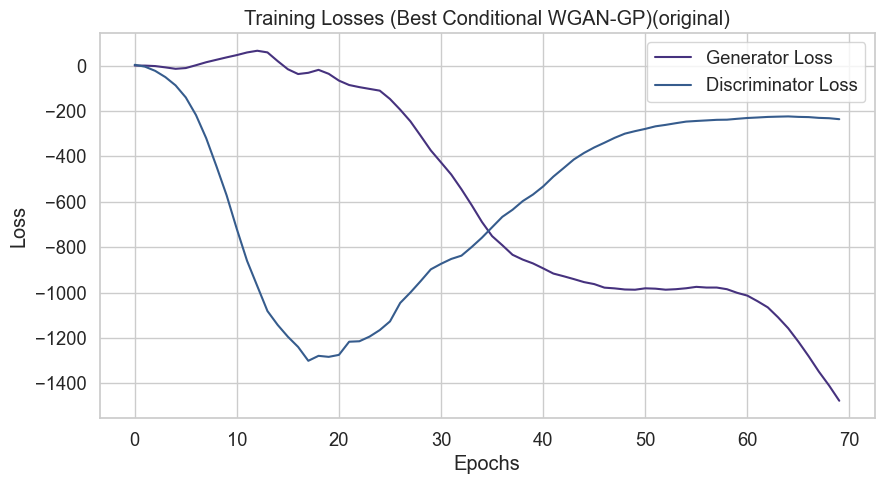

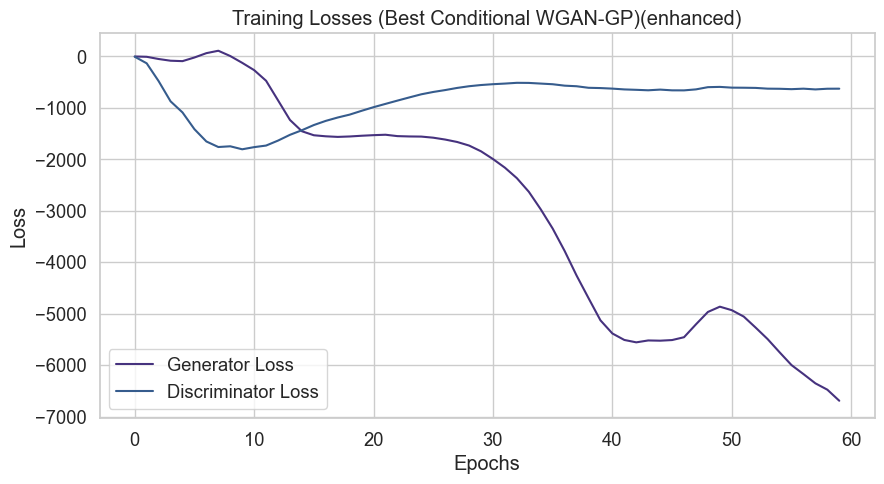

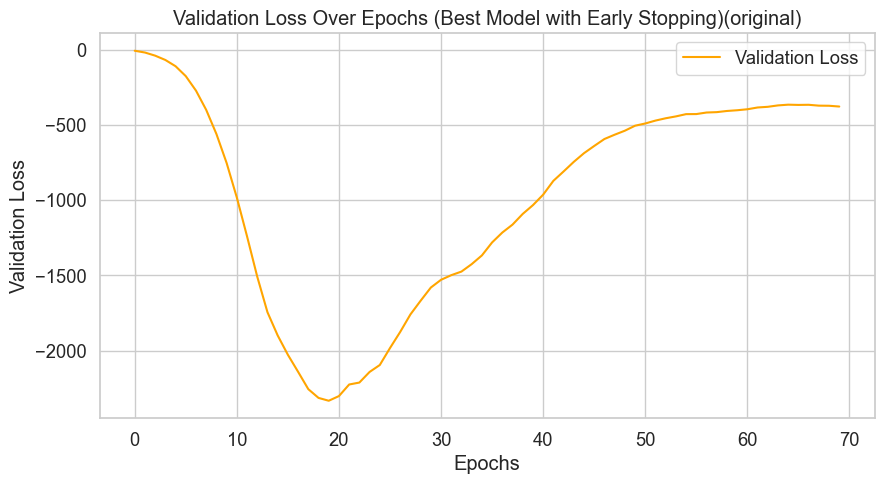

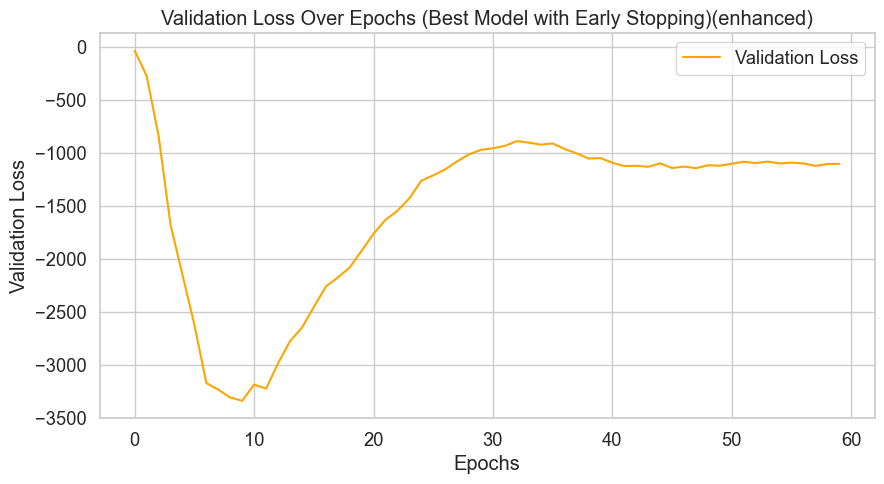

In [29]:
# For original
plt.figure(figsize=(10, 5))
plt.plot(G_losses_tune_orig, label="Generator Loss")
plt.plot(D_losses_tune_orig, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Losses (Best Conditional WGAN-GP)(original)")
plt.legend()
plt.show()

# Enhanced
plt.figure(figsize=(10, 5))
plt.plot(G_losses_tune_enh, label="Generator Loss")
plt.plot(D_losses_tune_enh, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Losses (Best Conditional WGAN-GP)(enhanced)")
plt.legend()
plt.show()

# Plot Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(val_losses_tune_orig, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Over Epochs (Best Model with Early Stopping)(original)")
plt.legend()
plt.show()

# Plot Validation Loss(enhanced)
plt.figure(figsize=(10, 5))
plt.plot(val_losses_tune_enh, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Over Epochs (Best Model with Early Stopping)(enhanced)")
plt.legend()
plt.show()

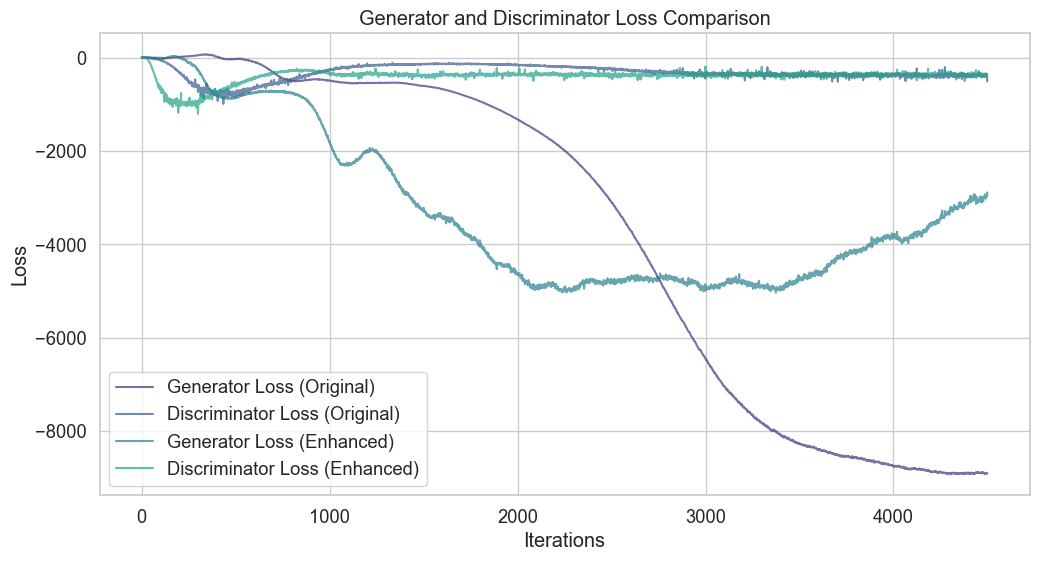

In [30]:
# Comparitive plot

plt.figure(figsize=(12, 6))
plt.plot(G_losses_orig, label='Generator Loss (Original)', alpha=0.7)
plt.plot(D_losses_orig, label='Discriminator Loss (Original)', alpha=0.7)
plt.plot(G_losses_enh, label='Generator Loss (Enhanced)', alpha=0.7)
plt.plot(D_losses_enh, label='Discriminator Loss (Enhanced)', alpha=0.7)
plt.title('Generator and Discriminator Loss Comparison')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 11. Enhanced Plot: Real vs. Synthetic EEG Comparison

We provide an enhanced plot that compares real and synthetic EEG signals.
For example, we overlay the average signals for a few channels from a real epoch vs. a synthetic epoch.



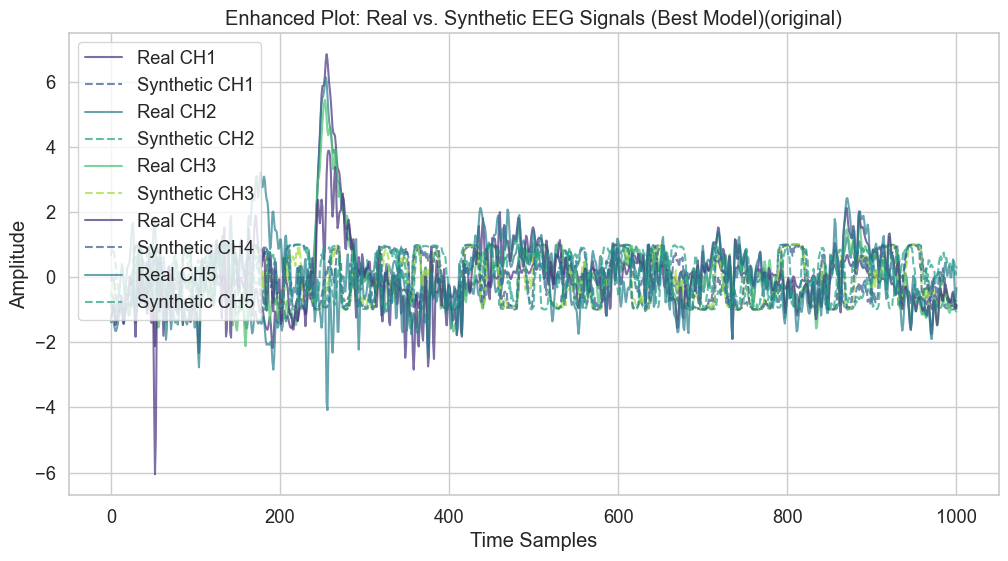

In [38]:
# Select a random real sample from validation set and generate synthetic sample using best generator
sample_idx = 0
real_sample = X_val[sample_idx]
real_label = Y_val[sample_idx]
real_label_tensor = torch.from_numpy(real_label).unsqueeze(0).to(device)

noise = torch.randn(1, latent_dim).to(device)
with torch.no_grad():
    synthetic_sample = best_generator_original(noise, real_label_tensor).cpu().numpy()[0]

# Plot comparison for the first 5 channels
plt.figure(figsize=(12, 6))
for ch in range(5):
    plt.plot(real_sample[ch, :], label=f"Real CH{ch+1}", alpha=0.7)
    plt.plot(synthetic_sample[ch, :], linestyle="dashed", label=f"Synthetic CH{ch+1}", alpha=0.7)
plt.legend()
plt.title("Enhanced Plot: Real vs. Synthetic EEG Signals (Best Model)(original)")
plt.xlabel("Time Samples")
plt.ylabel("Amplitude")
plt.show()

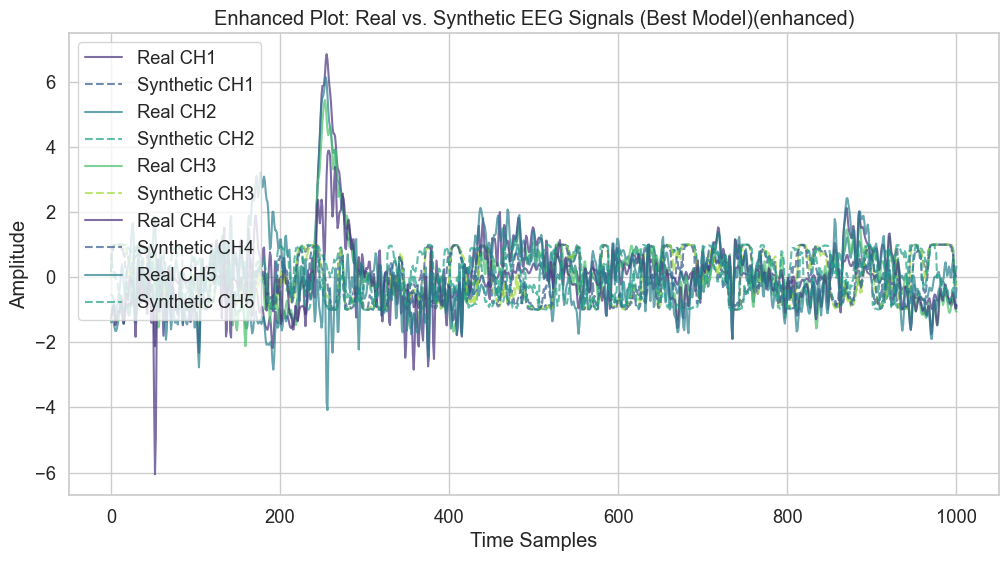

In [32]:
# Select a random real sample from validation set and generate synthetic sample using best generator
sample_idx = 0
real_sample = X_val[sample_idx]
real_label = Y_val[sample_idx]
real_label_tensor = torch.from_numpy(real_label).unsqueeze(0).to(device)

noise = torch.randn(1, latent_dim).to(device)
with torch.no_grad():
    synthetic_sample = best_generator_enhanced(noise, real_label_tensor).cpu().numpy()[0]

# Plot comparison for the first 5 channels
plt.figure(figsize=(12, 6))
for ch in range(5):
    plt.plot(real_sample[ch, :], label=f"Real CH{ch+1}", alpha=0.7)
    plt.plot(synthetic_sample[ch, :], linestyle="dashed", label=f"Synthetic CH{ch+1}", alpha=0.7)
plt.legend()
plt.title("Enhanced Plot: Real vs. Synthetic EEG Signals (Best Model)(enhanced)")
plt.xlabel("Time Samples")
plt.ylabel("Amplitude")
plt.show()

### Generate and Evaluate Synthetic EEG Samples

Now, we generate synthetic EEG epochs for a given class (e.g., label 0: “positive”) and visualize:
- Time-domain waveforms (for a subset of channels)
- Power Spectral Density (PSD) for one sample to check frequency content.

This evaluation helps answer whether the GAN produces realistic EEG signals and respects class conditioning.


/var/folders/3j/w0qrc74d6sj7fjdwc593xcqc0000gn/T/ipykernel_12745/3714498384.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", fontsize="small")


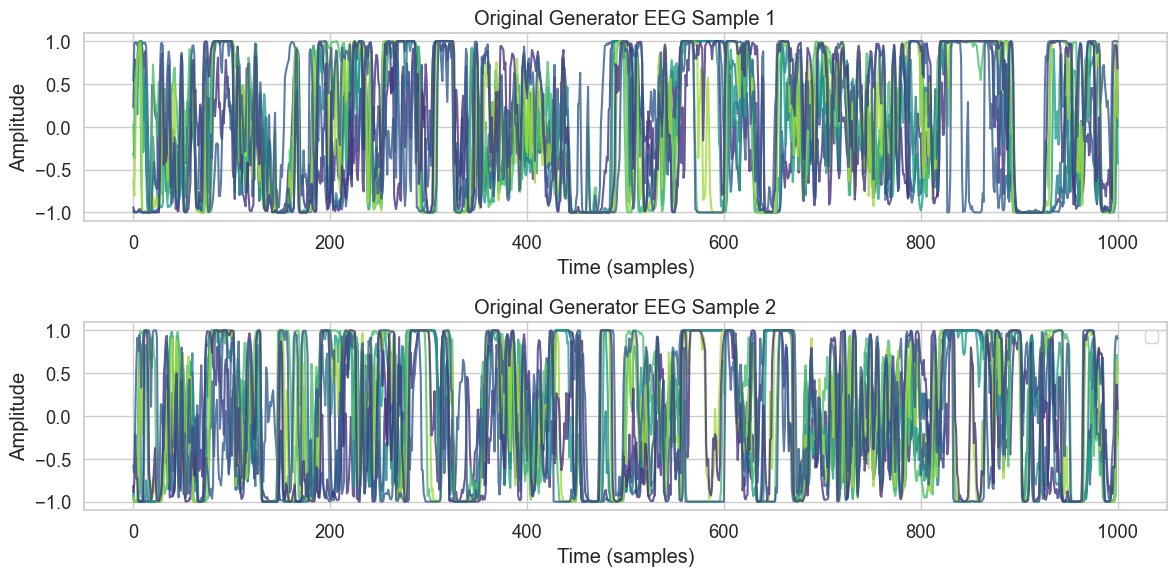

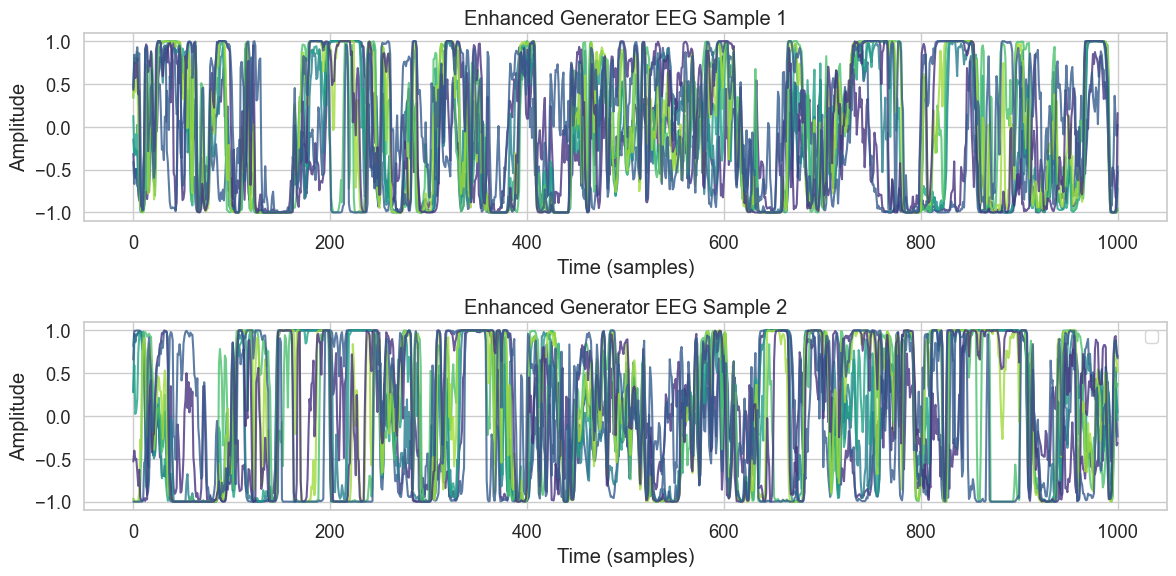

In [33]:
def generate_samples(generator, num_samples, label_int):
    labels = torch.zeros(num_samples, num_classes).to(device)
    labels[:, label_int] = 1
    noise = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        fake_samples = generator(noise, labels)
    return fake_samples.cpu().numpy()

def plot_generated_samples(generator, title):
    fake_samples = generate_samples(generator, 2, label_int=0)
    plt.figure(figsize=(12, 6))
    for i in range(2):
        plt.subplot(2, 1, i+1)
        for ch in range(8):
            plt.plot(fake_samples[i, ch, :], label=f"Ch {ch}" if i==0 else "", alpha=0.8)
        plt.title(f"{title} Sample {i+1}")
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.legend(loc="upper right", fontsize="small")
    plt.show()

# Plotting clearly labeled samples
plot_generated_samples(generator_original, "Original Generator EEG")
plot_generated_samples(generator_enhanced, "Enhanced Generator EEG")

#### Time-Domain Visualization

Plot a couple of generated EEG epochs (only first 8 channels) to inspect the waveform morphology.

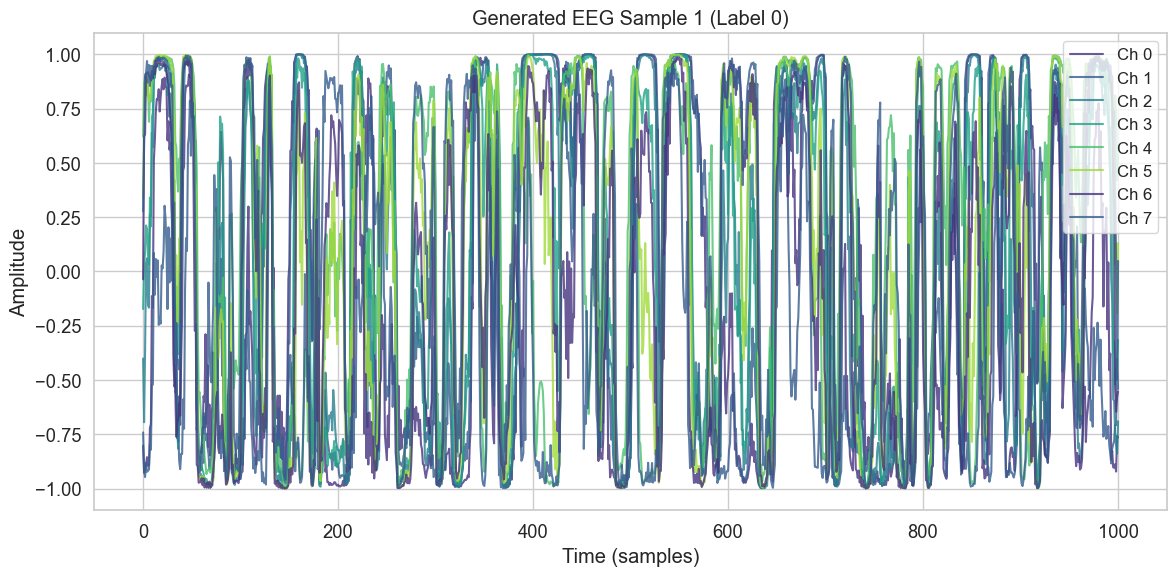

In [41]:
# Plot generated samples clearly for evaluation
num_to_plot = 1
# fake samples
fake_samples_original = generate_samples(best_generator_original, 2, label_int=0)

plt.figure(figsize=(12, 6))
for i in range(num_to_plot):
    plt.subplot(num_to_plot, 1, i+1)
    for ch in range(8):
        plt.plot(fake_samples_original[i, ch, :], label=f"Ch {ch}" if i==0 else "", alpha=0.8)
    plt.title(f"Generated EEG Sample {i+1} (Label 0)")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.legend(loc="upper right", fontsize="small")
plt.show()

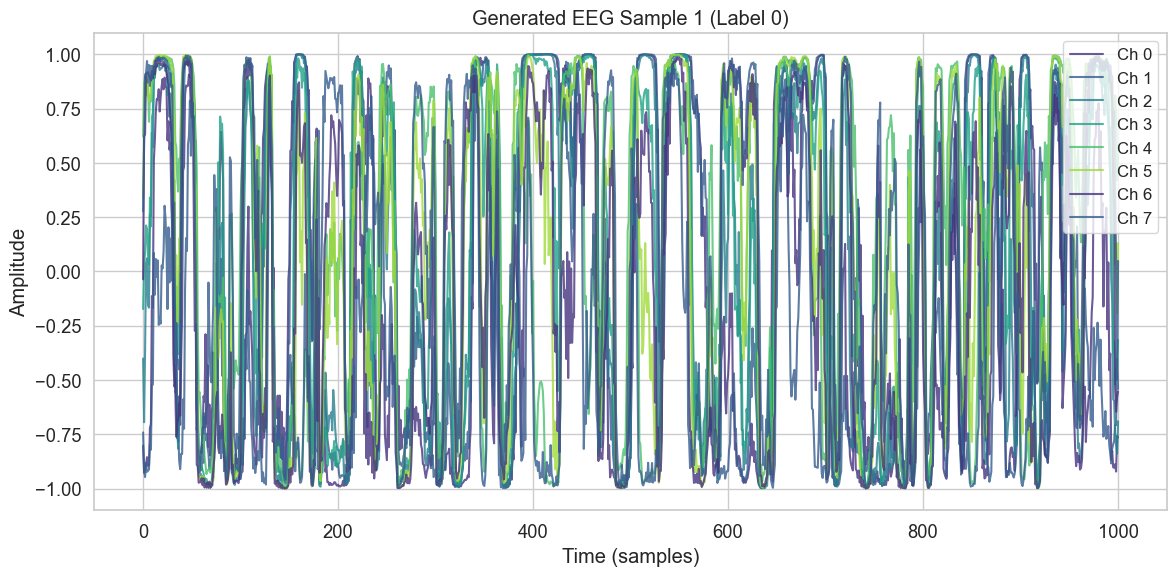

In [42]:
# Plot generated samples clearly for evaluation for enhanced
num_to_plot = 1
# fake samples
fake_samples_enhanced = generate_samples(best_generator_enhanced, 2, label_int=0)

plt.figure(figsize=(12, 6))
for i in range(num_to_plot):
    plt.subplot(num_to_plot, 1, i+1)
    for ch in range(8):
        plt.plot(fake_samples_original[i, ch, :], label=f"Ch {ch}" if i==0 else "", alpha=0.8)
    plt.title(f"Generated EEG Sample {i+1} (Label 0)")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.legend(loc="upper right", fontsize="small")
plt.show()

#### Power Spectral Density (PSD)

For one generated sample (channel 0), compute the PSD using Welch's method. We expect an EEG-like spectrum (with a 1/f trend and characteristic peaks).


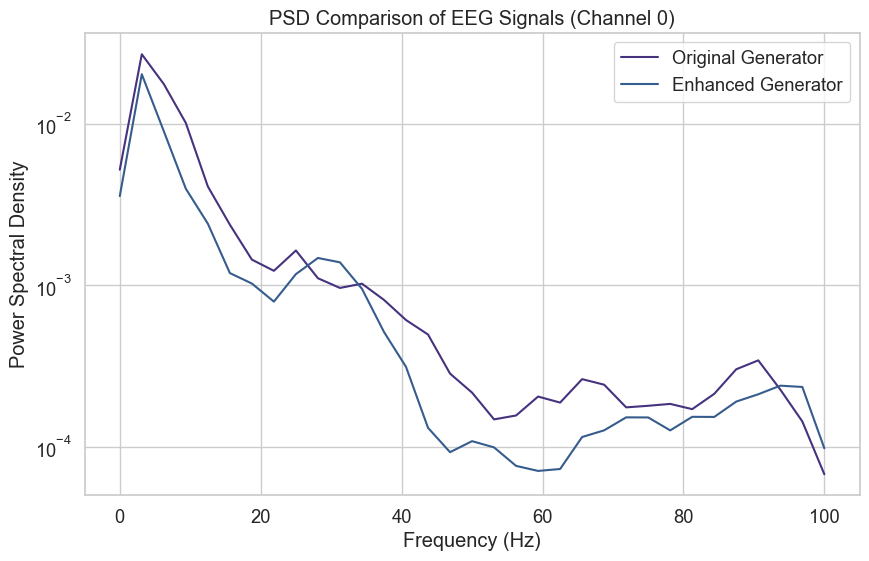

In [43]:
def plot_psd_comparison(generator1, generator2, channel=0):
    fs = 200
    plt.figure(figsize=(10, 6))
    for gen, label in zip([generator1, generator2], ["Original", "Enhanced"]):
        sample = generate_samples(gen, 1, label_int=0)[0, channel, :]
        freqs, psd = welch(sample, fs=fs, nperseg=64)
        plt.semilogy(freqs, psd, label=f'{label} Generator')
    plt.title("PSD Comparison of EEG Signals (Channel 0)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.legend()
    plt.show()

plot_psd_comparison(generator_original, generator_enhanced)